# DSCI 100 Group 17 Report
## Predicting Whether a Pokemon is legendary

## Introduction:
In the Pokemon game, you are tasked with catching various Pokemon that inhabit the world. While most of the Pokemon are very common, there exists a group of rare and powerful Pokemon known as Legendary Pokemon. **[see source 1]**

Our project's question is: **What variables can classify whether a Pokemon is legendary?** This is a **classification** problem. We will use the dataset “The Complete Pokemon Dataset” on Kaggle. **[see source 2]** It identifies 41 different variables for each of the 801 Pokemon. The variables are: <br>
- The 6 stats used in the game
- Base Total of all Stats
- Strength/weakness against each of the 18 typings
- Number of steps to hatch an egg of the pokemon
- Base Happiness 
- Capture Rate
- Classification
- Experience Growth
- Height
- Weight
- Name
- Japanese Name
- Gender Distribution
- Pokedex Number
- First Typing
- Second Typing
- Generation
- Is Legendary


## Methods and Results:
Here we load the libraries, set the seed, and load the dataset from the web: (Note that we use the themis package, so you might have to install the package first with install.packages("themis"))

In [1]:
library(themis)
library(RColorBrewer)
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(17)

pokemon_dataset <- read_csv("https://raw.githubusercontent.com/JerryMa0716/dsci-100-2023s1-group-17/main/data/pokemon.csv")

pokemon_dataset

Loading required package: recipes

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘recipes’


The following object is masked from ‘package:stats’:

    step


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ stringr::fixed() masks recipes::fixed()
✖ dplyr::lag()     masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0

abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,⋯,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
"['Overgrow', 'Chlorophyll']",1,1,1,0.5,0.5,0.5,2,2,1,⋯,88.1,1,65,65,45,grass,poison,6.9,1,0
"['Overgrow', 'Chlorophyll']",1,1,1,0.5,0.5,0.5,2,2,1,⋯,88.1,2,80,80,60,grass,poison,13.0,1,0
"['Overgrow', 'Chlorophyll']",1,1,1,0.5,0.5,0.5,2,2,1,⋯,88.1,3,122,120,80,grass,poison,100.0,1,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
['Beast Boost'],2.00,0.5,2,0.5,4.0,2.0,0.5,1.0,0.5,⋯,NA,799,97,53,43,dark,dragon,888.0,7,1
['Prism Armor'],2.00,2.0,1,1.0,1.0,0.5,1.0,1.0,2.0,⋯,NA,800,127,89,79,psychic,NA,230.0,7,1
['Soul-Heart'],0.25,0.5,0,1.0,0.5,1.0,2.0,0.5,1.0,⋯,NA,801,130,115,65,steel,fairy,80.5,7,1


The original dataset above is table 1. <br> <br>
Next we make the data tidy. The "abilities" column has multiple values in a single cell, so we split that column up. We also do some other minor adjustments to the data. (see comments)

In [2]:
tidy_pokemon_dataset <- pokemon_dataset |>
                        mutate(abilities = substr(abilities, 2, nchar(abilities) - 1)) |>                    # remove square brackets at start and end.
                        mutate(abilities = gsub("'", "", abilities)) |>                                      # remove quotation marks.
                        separate(abilities,                                                                  # split by comma.
                                 c("ability1", "ability2", "ability3", "ability4", "ability5", "ability6"),  # (some rows have up to 6 abilities in a cell.)
                                 sep = ",") |>
                        mutate(is_legendary = as_factor(is_legendary)) |>                                    # convert to factor                         
                        mutate(capture_rate = ifelse(row_number() == 774, "30", capture_rate)) |>            # Row 774 is the only pokemon with 2 forms and different
                        mutate(capture_rate = as.numeric(capture_rate))                                      # catch rates per form. We choose the most common form's catch rate.


# select is_legendary, and the predictor variables. (see justification for predictor choice later)
# also remove any rows that have NA for predictor values
no_NA_tidy_pokemon_dataset <- select(tidy_pokemon_dataset, is_legendary, weight_kg, height_m, experience_growth, capture_rate, base_total) |>
                                na.omit()

no_NA_tidy_pokemon_dataset

Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 788 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, ...].”


is_legendary,weight_kg,height_m,experience_growth,capture_rate,base_total
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,6.9,0.7,1059860,45,318
0,13.0,1.0,1059860,45,405
0,100.0,2.0,1059860,45,625
⋮,⋮,⋮,⋮,⋮,⋮
1,888.0,5.5,1250000,15,570
1,230.0,2.4,1250000,3,600
1,80.5,1.0,1250000,3,600


The tidy dataset above is table 2. 
<br><br> From our dataset, the variables we will use to perform our prediction are base total stats, capture rate, experience growth, height, and weight. These variables were the ones chosen since they were closely related to features unique to legendary pokemon. Variables such as name, classification, and pokedex number weren’t used since they directly identified a pokemon, hence being unsuitable for prediction. Generation only relates to when a pokemon was first introduced, which also doesn’t aid in determining if a pokemon is legendary or not. Typing isn’t used since it is arbitrarily given to each pokemon, hence not being a good indicator for our goal. Additionally, strengths and weaknesses aren’t used since it directly depends on typing. Similarly, base happiness is also generally arbitrary. Gender Distribution isn’t used since various pokemon and legendaries do not have a gender. Individual stats weren’t used since they are represented in the Base Total, which is an accumulation of all the stats for the given pokemon. Finally, egg steps weren’t used since legendary pokemon can’t be found in eggs. For more explanation, see the plots and tables below

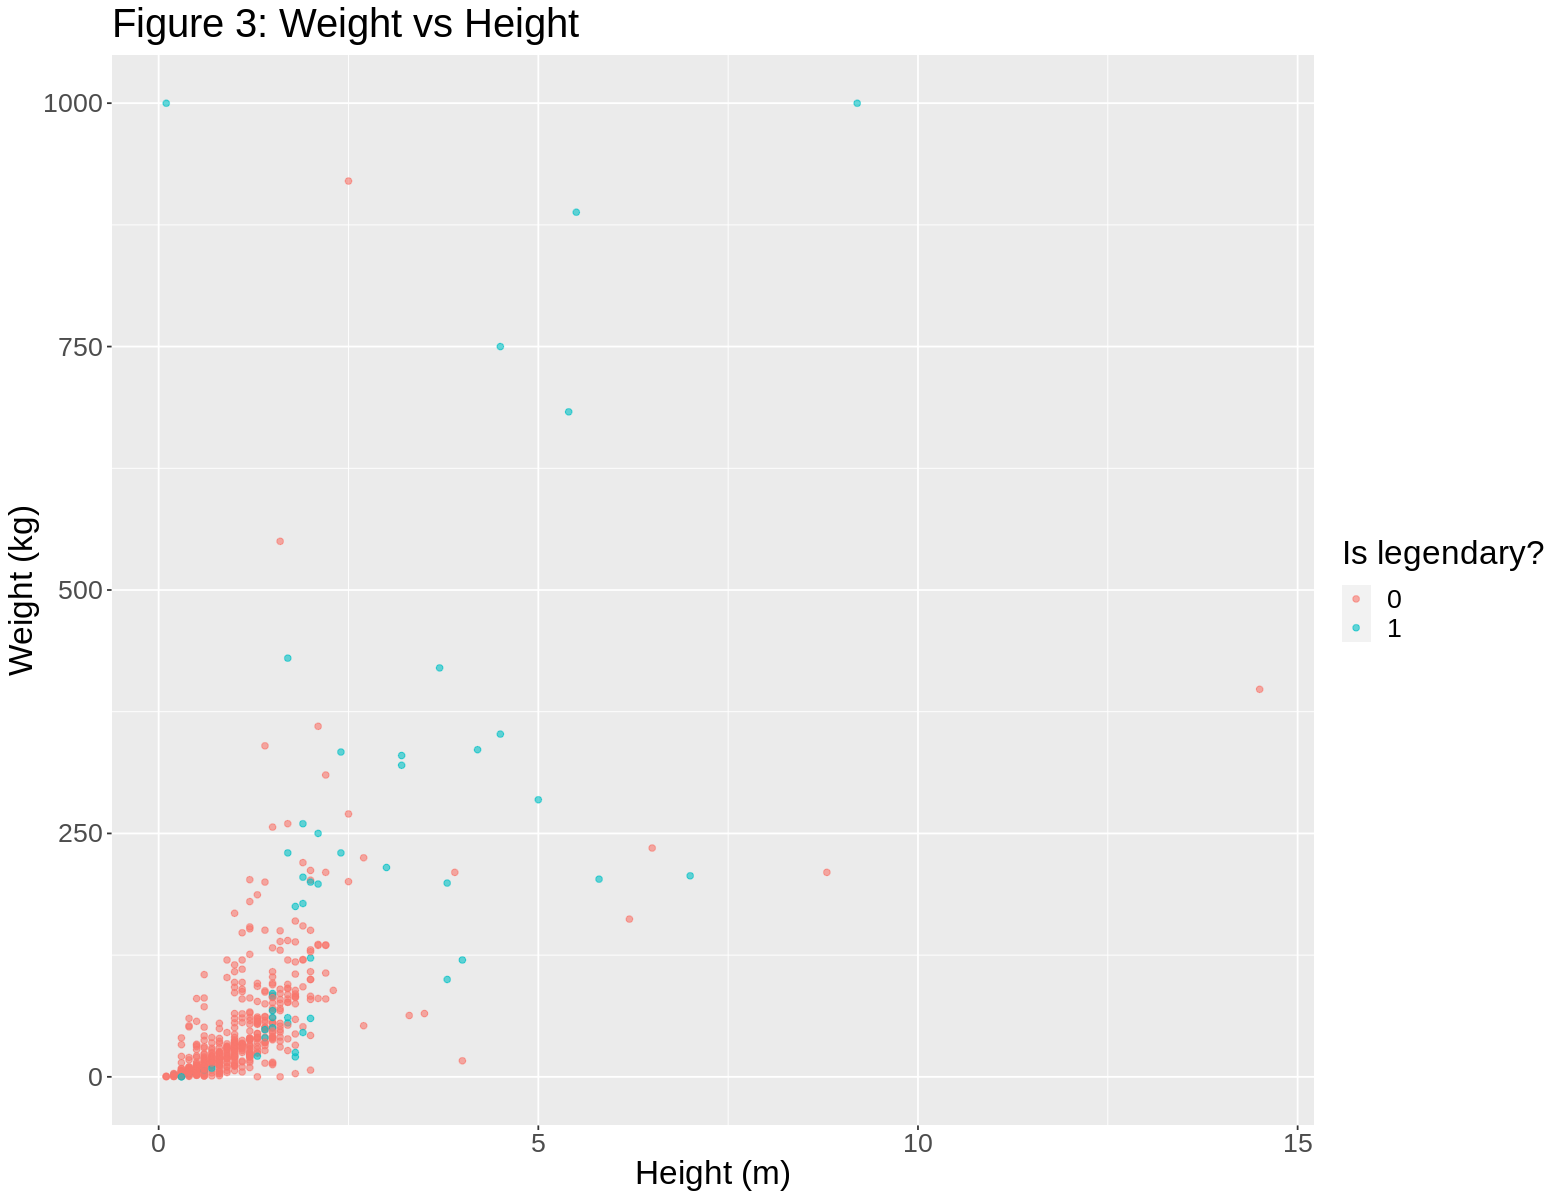

In [3]:
pokemon_split <- initial_split(no_NA_tidy_pokemon_dataset, prop = 0.75, strata = is_legendary)
pokemon_train <- training(pokemon_split)
pokemon_test <- testing(pokemon_split)


options(repr.plot.width = 13, repr.plot.height = 10) 

# included alpha value due to overplotting
pokemon_plot_height_weight <- ggplot(pokemon_train, aes(x = height_m, y = weight_kg, color = is_legendary)) +
                geom_point(alpha = 0.6) +
                theme(text = element_text(size = 20)) +
                labs(x = "Height (m)", y = "Weight (kg)", color = "Is legendary?") +
                ggtitle("Figure 3: Weight vs Height")

pokemon_plot_height_weight

The correlation between a Pokemon's height and weight is shown in this graph. It offers a visual representation of the distribution of height and weight measurements among various Pokemon species. Pokemon's height is shown on the x-axis in meters, and their weight is represented on the y-axis in kilograms. To determine whether a Pokemon is legendary, we use the colors red and blue. (For this graph and all other relevant graphs, 0 means not a legendary, and 1 means is a legendary) It seems that legendary pokemon tend to have greater height and weight, which is why we are using those variables as predictors.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



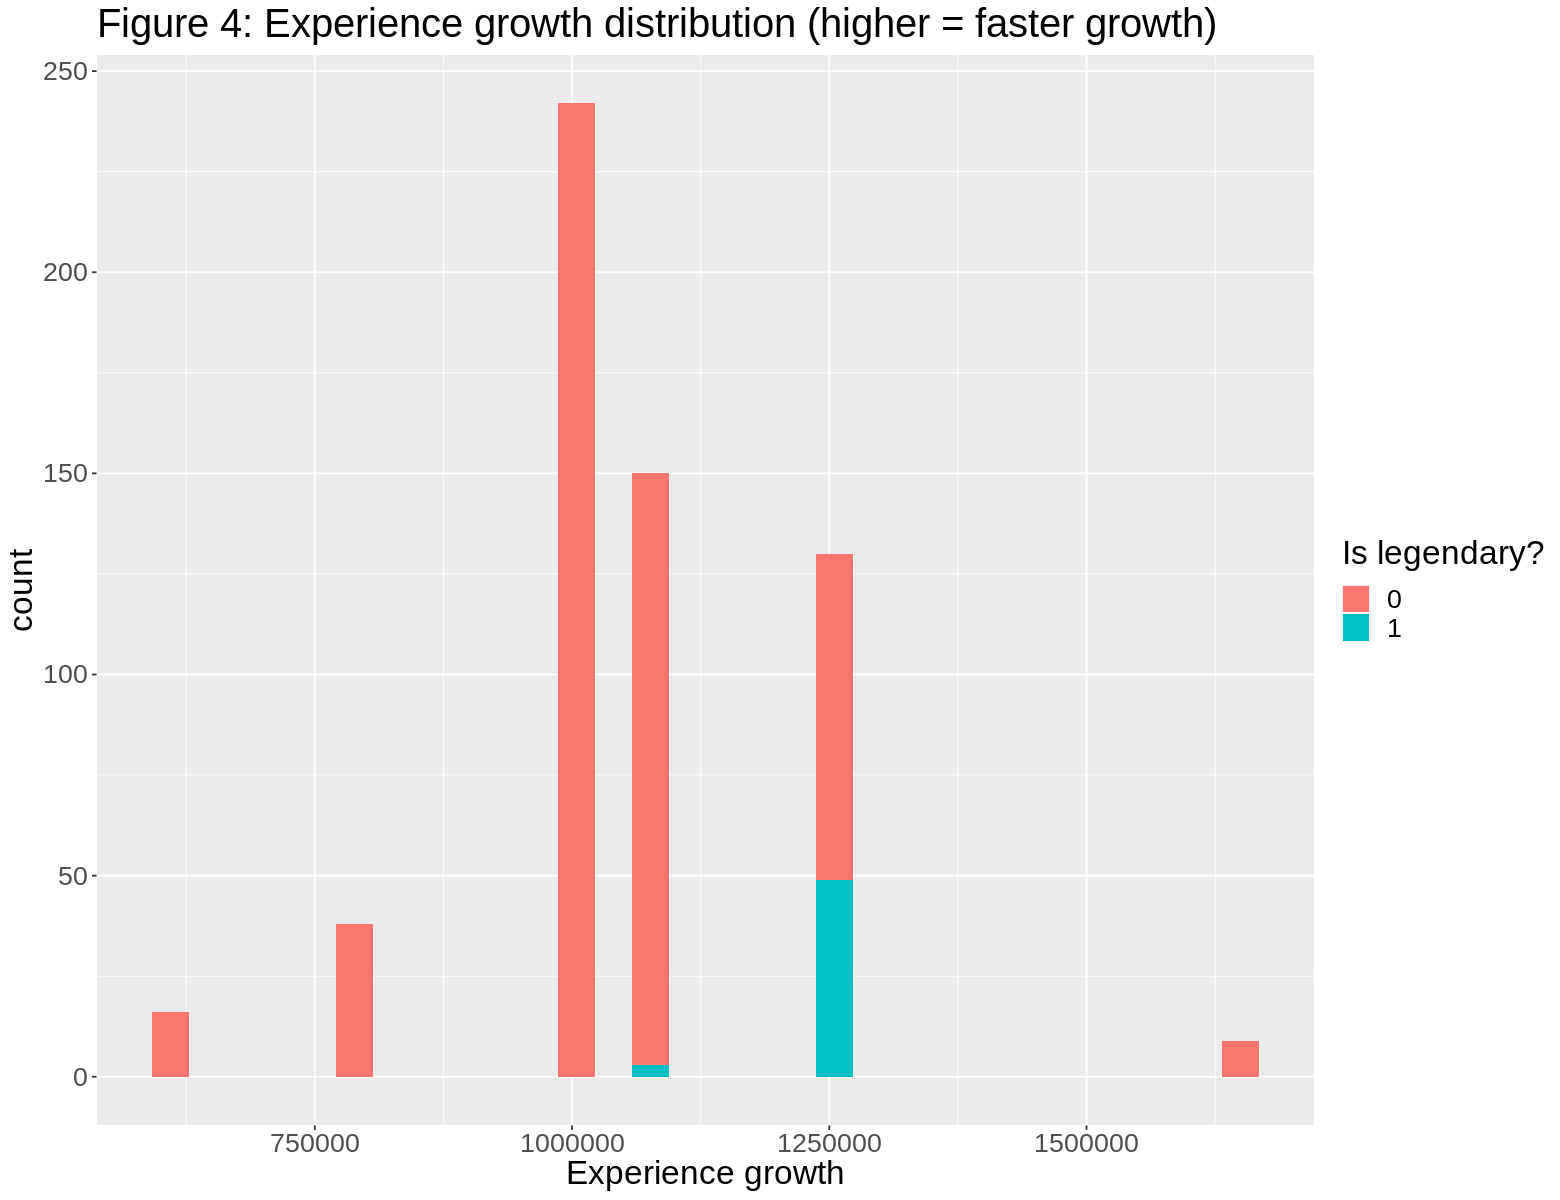

In [4]:
pokemon_plot_experience_growth <- ggplot(pokemon_train, aes(x = experience_growth, fill = is_legendary)) +
                geom_histogram() +
                theme(text = element_text(size = 20)) +
                labs(x = "Experience growth", fill = "Is legendary?") +
                ggtitle("Figure 4: Experience growth distribution (higher = faster growth)")

pokemon_plot_experience_growth

The distribution of experience growth patterns among Pokemon species is seen in this graph. It shows how frequently various experience growth occurs in the dataset. The y-axis shows the amount of Pokemon species that have that experience growth, while the x-axis shows the various experience growth, with larger numbers meaning slower experience growth. To determine whether a Pokemon is legendary, we use the colors red and blue. It seems that most legendary pokemon have 1250000 experience growth (slow experience growth) **[see source 3]**, which is why we are using experience growth as a predictor. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



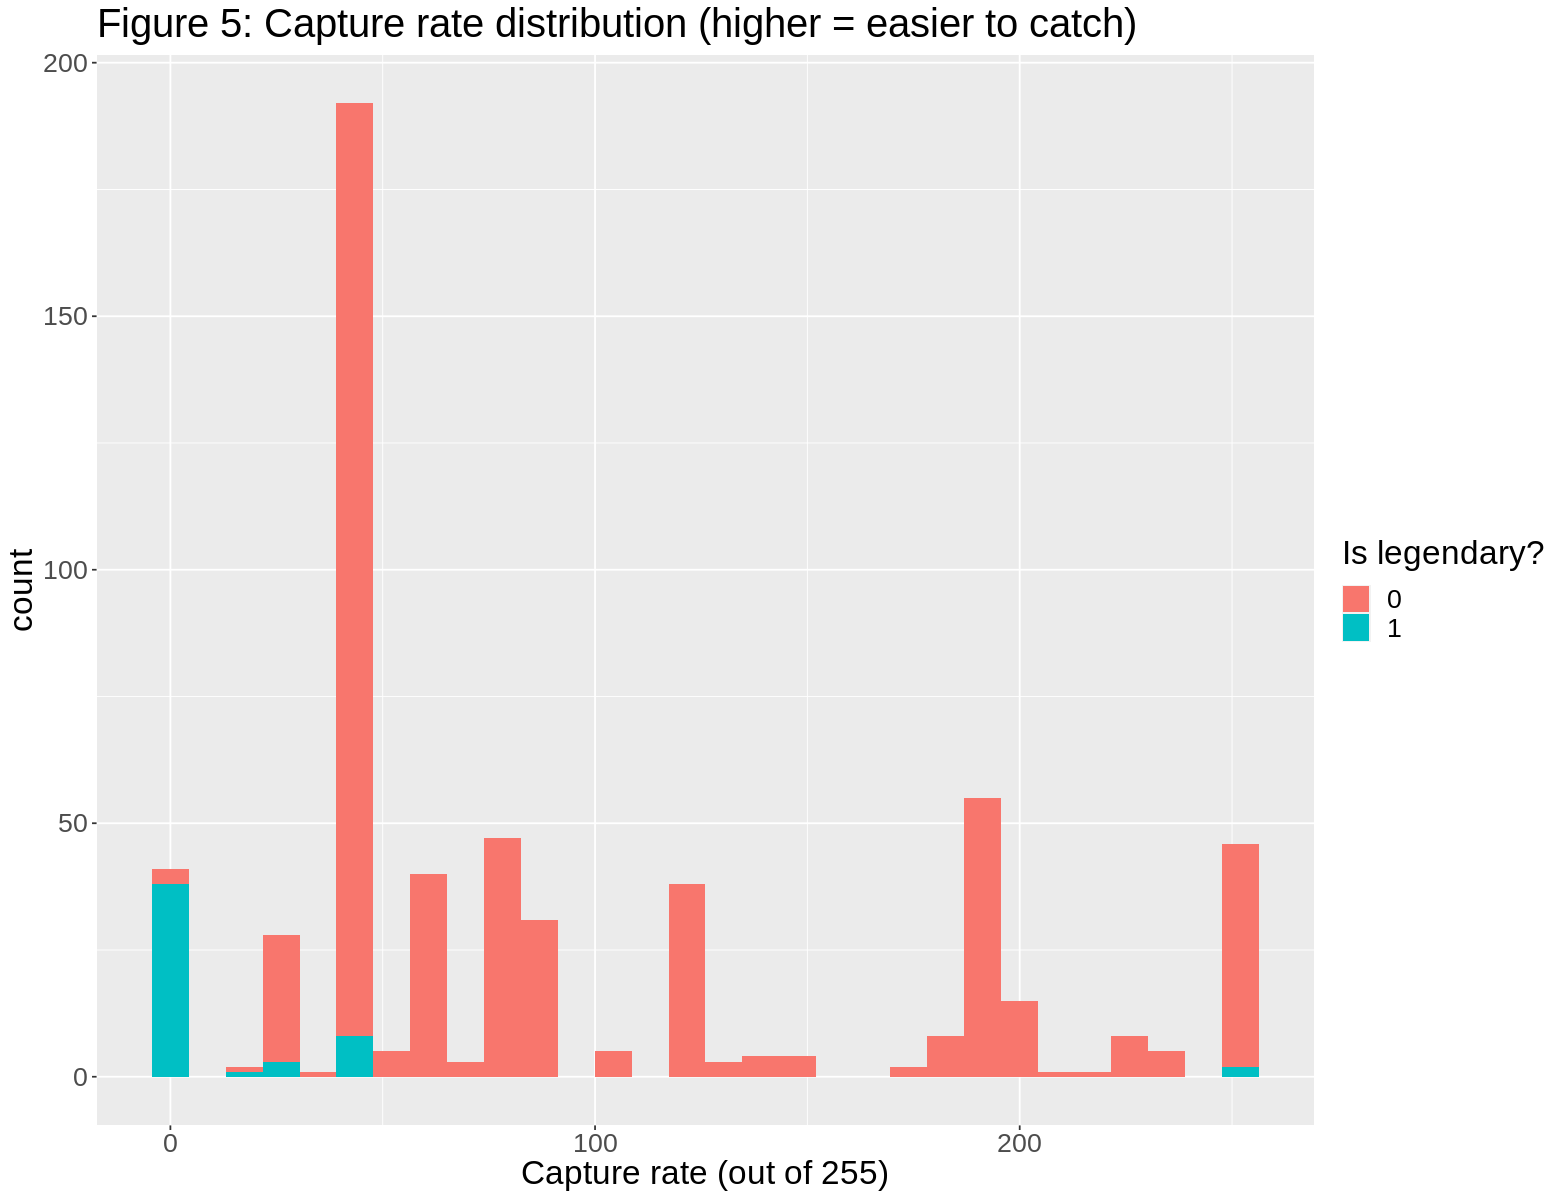

In [5]:
pokemon_plot_capture_rate <- ggplot(pokemon_train, aes(x = capture_rate, fill = is_legendary)) +
                geom_histogram() +
                theme(text = element_text(size = 20)) +
                labs(x = "Capture rate (out of 255)", fill = "Is legendary?") +
                ggtitle("Figure 5: Capture rate distribution (higher = easier to catch)")

pokemon_plot_capture_rate

The dataset’s Pokemon species’ distribution of capture rates is shown in the distribution of capture rates graph. The y-axis shows the quantity of Pokemon species that have a particular capture rate, with the x-axis showing capture rates ranging from low to high. (Note that lower capture rate means that you are less likely to capture it) We use blue and red to distinguish if a Pokemon is legendary. It seems that legendary pokemon tend to have much lower catch rates, which is why we are using it as a predictor.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



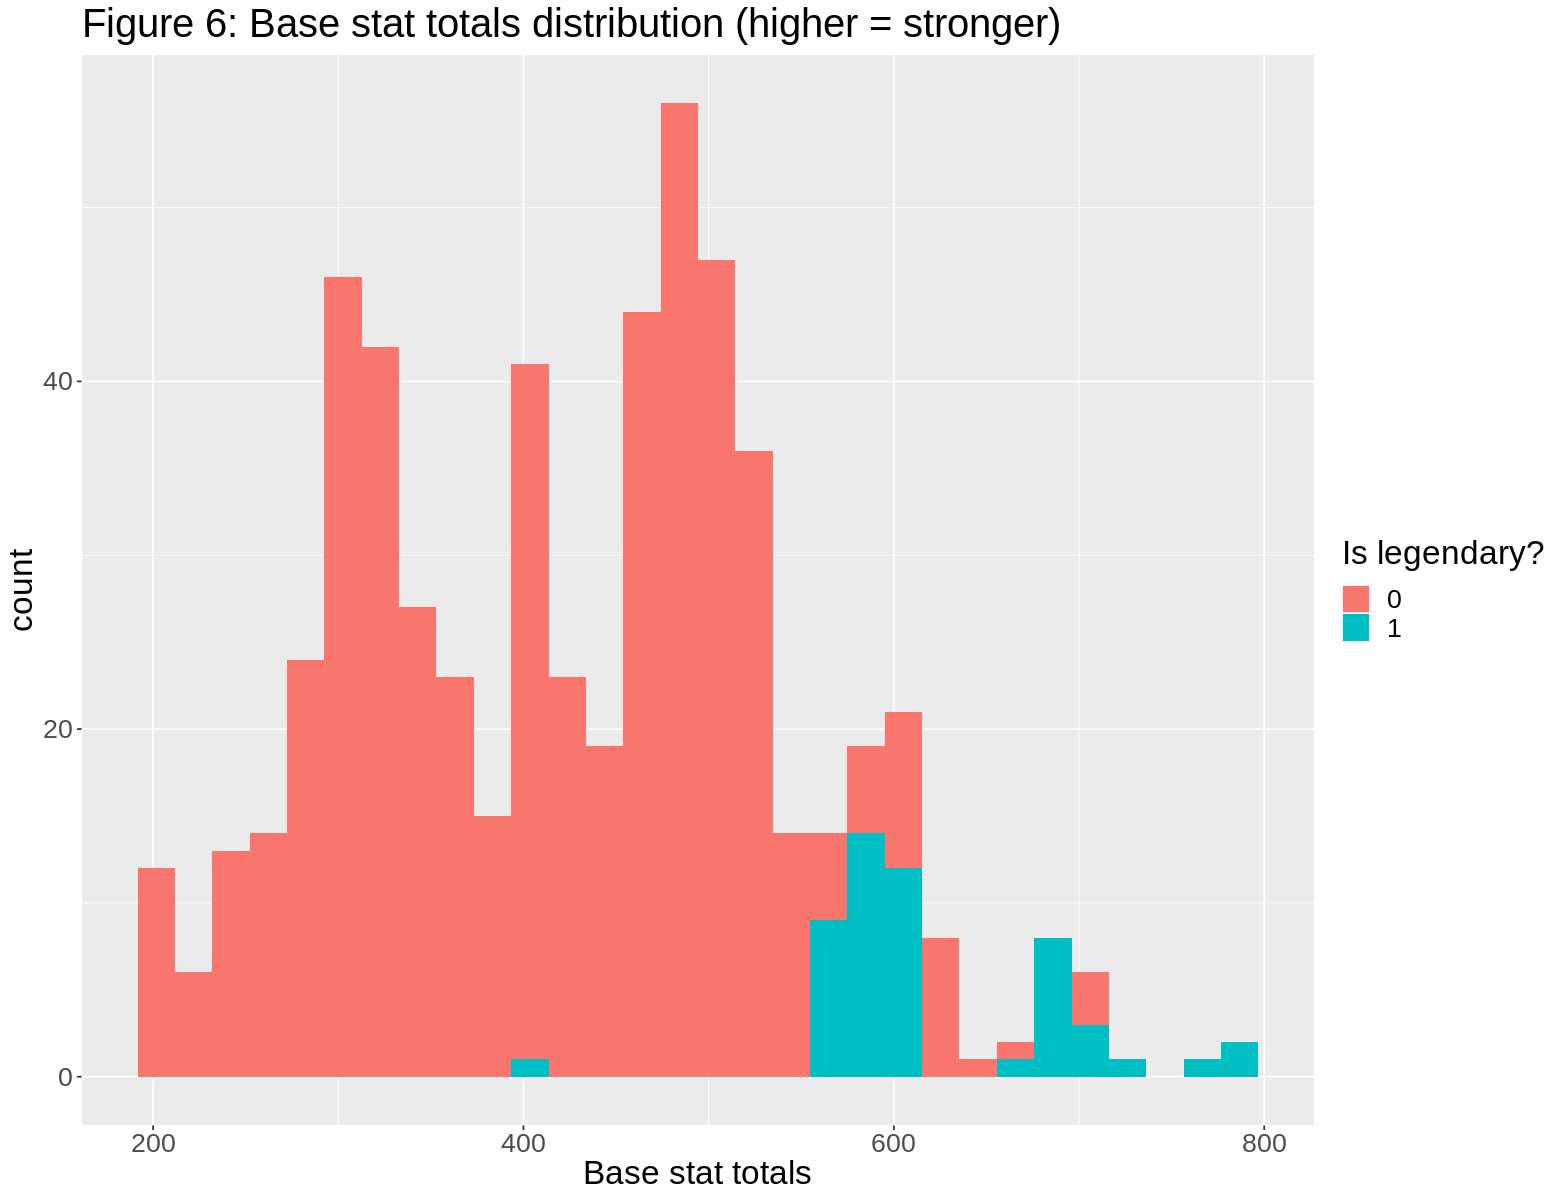

In [6]:
pokemon_plot_base_stats <- ggplot(pokemon_train, aes(x = base_total, fill = is_legendary)) +
                geom_histogram() +
                theme(text = element_text(size = 20)) +
                labs(x = "Base stat totals", fill = "Is legendary?") +
                ggtitle("Figure 6: Base stat totals distribution (higher = stronger)")

pokemon_plot_base_stats

The distribution of base stat totals among Pokemon species is seen in this graph. The cumulative values of numerous qualities (such as HP, Attack, Defence, and Speed) that constitute a Pokemon’s overall strength are represented by the base stat totals on the x-axis. (Note that higher base stats means that a Pokemon is "stronger" in battle) The amount of Pokemon species that fall under each base stat total is shown on the y-axis. Once again we mark the legendary and non-legendary pokemon with the colors red and blue. It seems that legendary pokemon tend to have much higher base stat totals, which is why we are using it as a predictor.

<br> We can see that legendary pokemon tend to be taller, heavier, have higher experience growth, lower capture rate, and higher base stat totals. Below, the tables show averages of the predictor variables for both legendaries and non-legendaries.

In [7]:
num_legendaries <- pokemon_train |>
                    group_by(is_legendary) |>
                    summarize(count = n())

weight_mean <- pokemon_train |>
                    group_by(is_legendary) |>
                    summarize(avg_weight = mean(weight_kg, na.rm = TRUE))

height_mean <- pokemon_train |>
                    group_by(is_legendary) |>
                    summarize(avg_height = mean(height_m, na.rm = TRUE))
base_total_mean <- pokemon_train |>
                    group_by(is_legendary) |>
                    summarize(avg_base_total = mean(base_total, na.rm = TRUE))

exp_mean <- pokemon_train |>
                    group_by(is_legendary) |>
                    summarize(avg_experience_growth = mean(experience_growth, na.rm = TRUE))

capture_mean <- pokemon_train |>
                    group_by(is_legendary) |>
                    summarize(avg_capture_rate = mean(capture_rate, na.rm = TRUE))


summary_table <- num_legendaries |>
                    bind_cols(select(weight_mean, -is_legendary)) |>
                    bind_cols(select(height_mean, -is_legendary)) |>
                    bind_cols(select(base_total_mean, -is_legendary)) |>
                    bind_cols(select(exp_mean, -is_legendary)) |>
                    bind_cols(select(capture_mean, -is_legendary))

summary_table

is_legendary,count,avg_weight,avg_height,avg_base_total,avg_experience_growth,avg_capture_rate
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,533,46.72176,1.062477,412.0844,1039042,102.6698
1,52,211.04038,2.425000,617.6538,1239030,20.7500


The table above is table 7. <br><br>

The table shows the average values of each predictor variable for both legendary and non-legendary pokemon. This table supports figures 3 to 6, showing that legendary pokemon have on average higher weight, higher height, higher base stat totals, higher experience growth, and lower capture rate.

In [8]:
num_NA_height <- sum(is.na(pokemon_train$height_m))
num_NA_weight <- sum(is.na(pokemon_train$weight_kg))
num_NA_base_total <- sum(is.na(pokemon_train$base_total))
num_NA_capture_rate <- sum(is.na(pokemon_train$capture_rate))
num_NA_experience_growth <- sum(is.na(pokemon_train$experience_growth))

num_NA_vec <- c("missing height rows" = num_NA_height,
                "missing weight rows" = num_NA_weight,
                "missing base total rows" = num_NA_base_total,
                "missing capture rate rows" = num_NA_capture_rate,
                "missing experience growth rows" = num_NA_experience_growth)

num_NA_table <- bind_rows(num_NA_vec)
num_NA_table

missing height rows,missing weight rows,missing base total rows,missing capture rate rows,missing experience growth rows
<int>,<int>,<int>,<int>,<int>
0,0,0,0,0


The table above is table 8. <br><br>

As an aside, we double check that there are no more rows with missing values (NA). Indeed, there are not, as we had removed the rows earlier.

<br><br>
Based on tables and plots 3 to 7, weight, height, base stat total, experience growth, and capture rate clearly tend to have different values for legendary and non-legendary pokemon and therefore will be useful for predicting, so we use them as our predictor variables. <br>

For our data analysis, we will use a classification method known as K-nearest neighbors to see what a new observation most closely matches with. The first step is to split our initial dataset into two parts, a training subset and a testing subset, with a 3:1 split. We have already done so above, in the code block between table 2 and figure 3. Afterwards, in the code block below, we will center and scale our data, because some of our predictors are on different scales of magnitude. We also want to upsample, to balance the number of legendary and non-legendary pokemon. This is because around 90% of the training dataset is non-legendary, and only around 10% of the training dataset is legendary. Then we perform cross-validation to select the best number of neighbors (k), splitting our training data into 5 folds.


In [9]:
# choose k from the range (1,20)
k_choices <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

# our model specification uses k-nearest neighbor and is classification
pokemon_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                                    set_engine("kknn") |>
                                    set_mode("classification")

# we scale and center all our predictors. We also upsample.
pokemon_recipe <- recipe(is_legendary ~ height_m + weight_kg + base_total + experience_growth + capture_rate, 
                            data = pokemon_train) |>
                                step_scale(all_predictors()) |>
                                step_center(all_predictors()) |>
                                step_upsample(is_legendary, over_ratio = 1, skip = TRUE)

# we split our data into 5 folds
pokemon_vfold <- vfold_cv(pokemon_train, v = 5, strata = is_legendary)

# we run the cross validation for each k choice
pokemon_fit <- workflow() |>
                add_recipe(pokemon_recipe) |>
                add_model(pokemon_spec) |>
                tune_grid(resamples = pokemon_vfold, grid = k_choices)

# collect the accuracies for each k
pokemon_accuracies <- collect_metrics(pokemon_fit) |>
                        filter(.metric == "accuracy")

<br>Having collected the accuracies for each k choice, we now visualize the accuracies by creating a line plot.

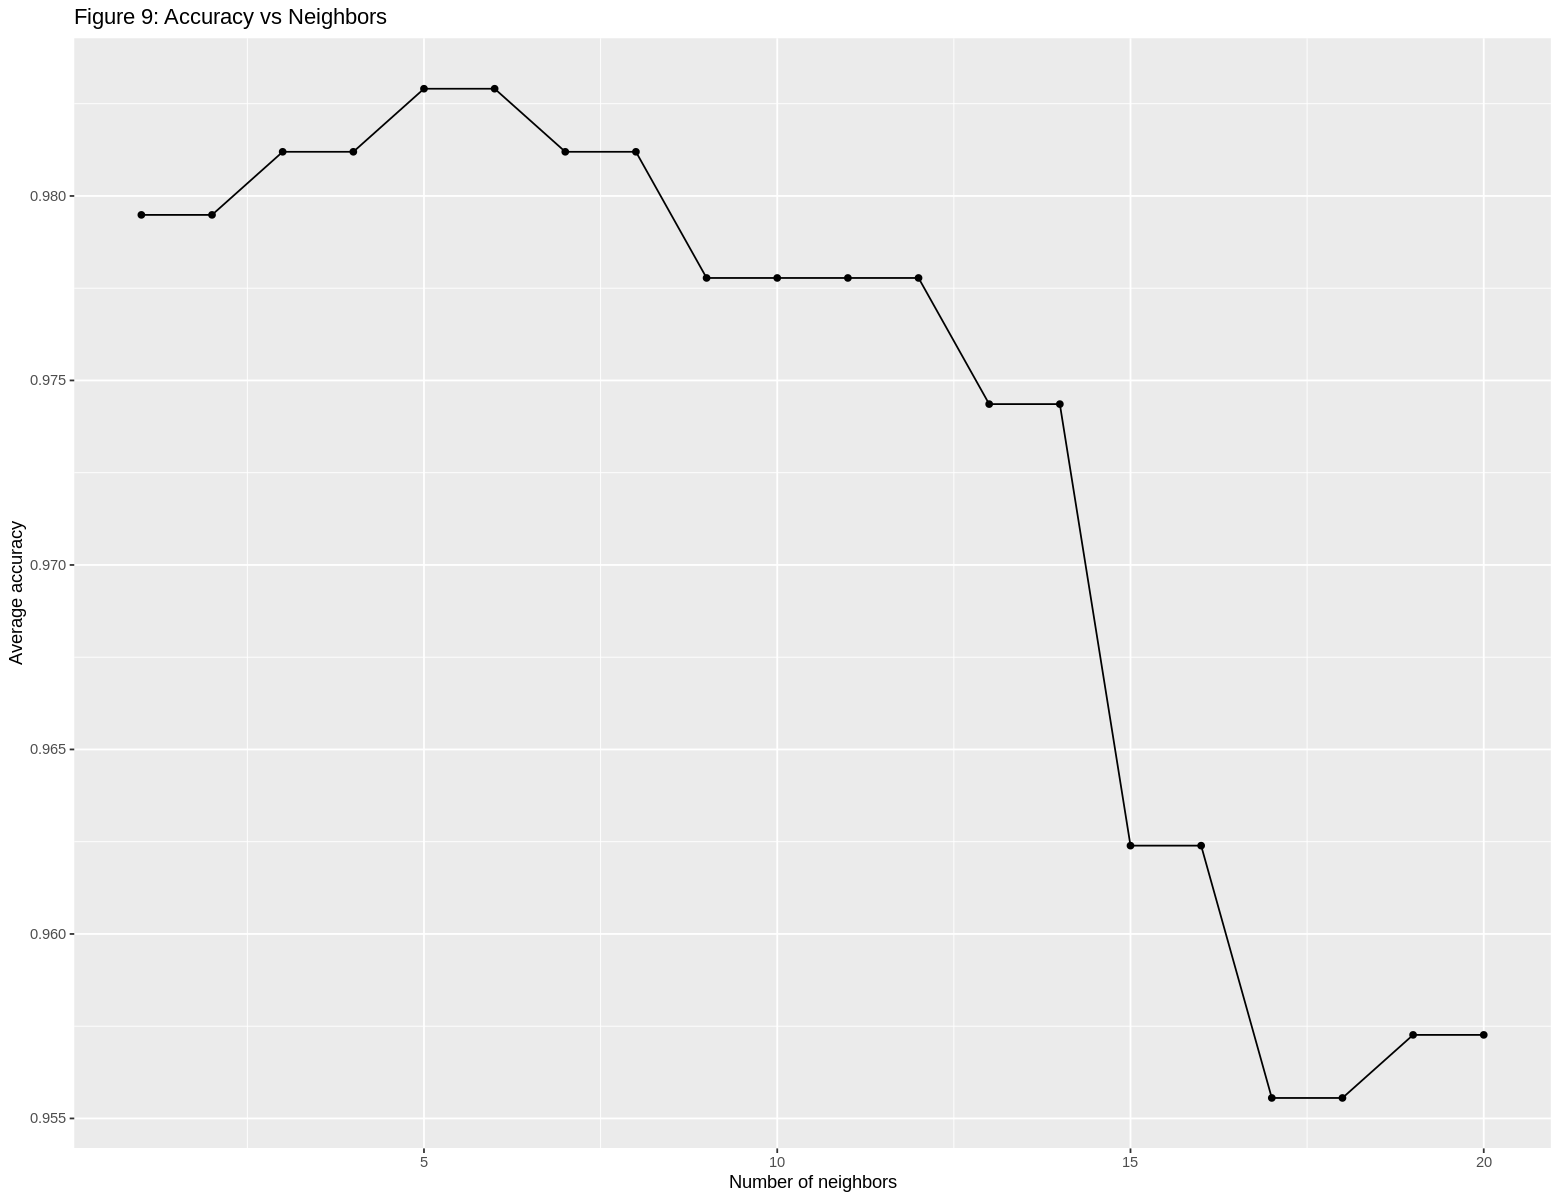

In [10]:
k_plot <- ggplot(pokemon_accuracies, aes(x = neighbors, y = mean)) +
            geom_point() +
            geom_line() +
            labs(x = "Number of neighbors", y = "Average accuracy") +
            ggtitle("Figure 9: Accuracy vs Neighbors")
k_plot

From figure 9, choosing K = 5 results in the highest accuracy. Therefore, we will build our model with k = 5.

In [11]:
best_k <- 5

# model specification now uses k = 5
pokemon_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
                                    set_engine("kknn") |>
                                    set_mode("classification")


pokemon_best_fit <- workflow() |>
                add_recipe(pokemon_recipe) |>
                add_model(pokemon_best_spec) |>
                fit(data = pokemon_train)

<br> Using our new model, we will predict on the test dataset and check the accuracy.

In [12]:
pokemon_predictions <- predict(pokemon_best_fit, pokemon_test) |>
                            bind_cols(pokemon_test)


pokemon_test_accuracy <- pokemon_predictions |>
                            metrics(truth = is_legendary, estimate = .pred_class) |>
                            filter(.metric == "accuracy")


pokemon_test_accuracy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9591837


The table above is table 10. <br>

We see that we get a accuracy of 95.9%. We will also construct a confusion matrix.

In [13]:
pokemon_test_matrix <- pokemon_predictions |>
                conf_mat(truth = is_legendary, estimate = .pred_class)

pokemon_test_matrix

          Truth
Prediction   0   1
         0 173   2
         1   6  15

The confusion matrix above is figure 11. <br>

We see that 6 non-legendary pokemon were incorrectly predicted as legendary, and 2 legendary pokemon were incorrectly predicted as non-legendary. <br> <br><br>

We will also create some visualizations to better understand why some pokemon were predicted incorrectly by our model.

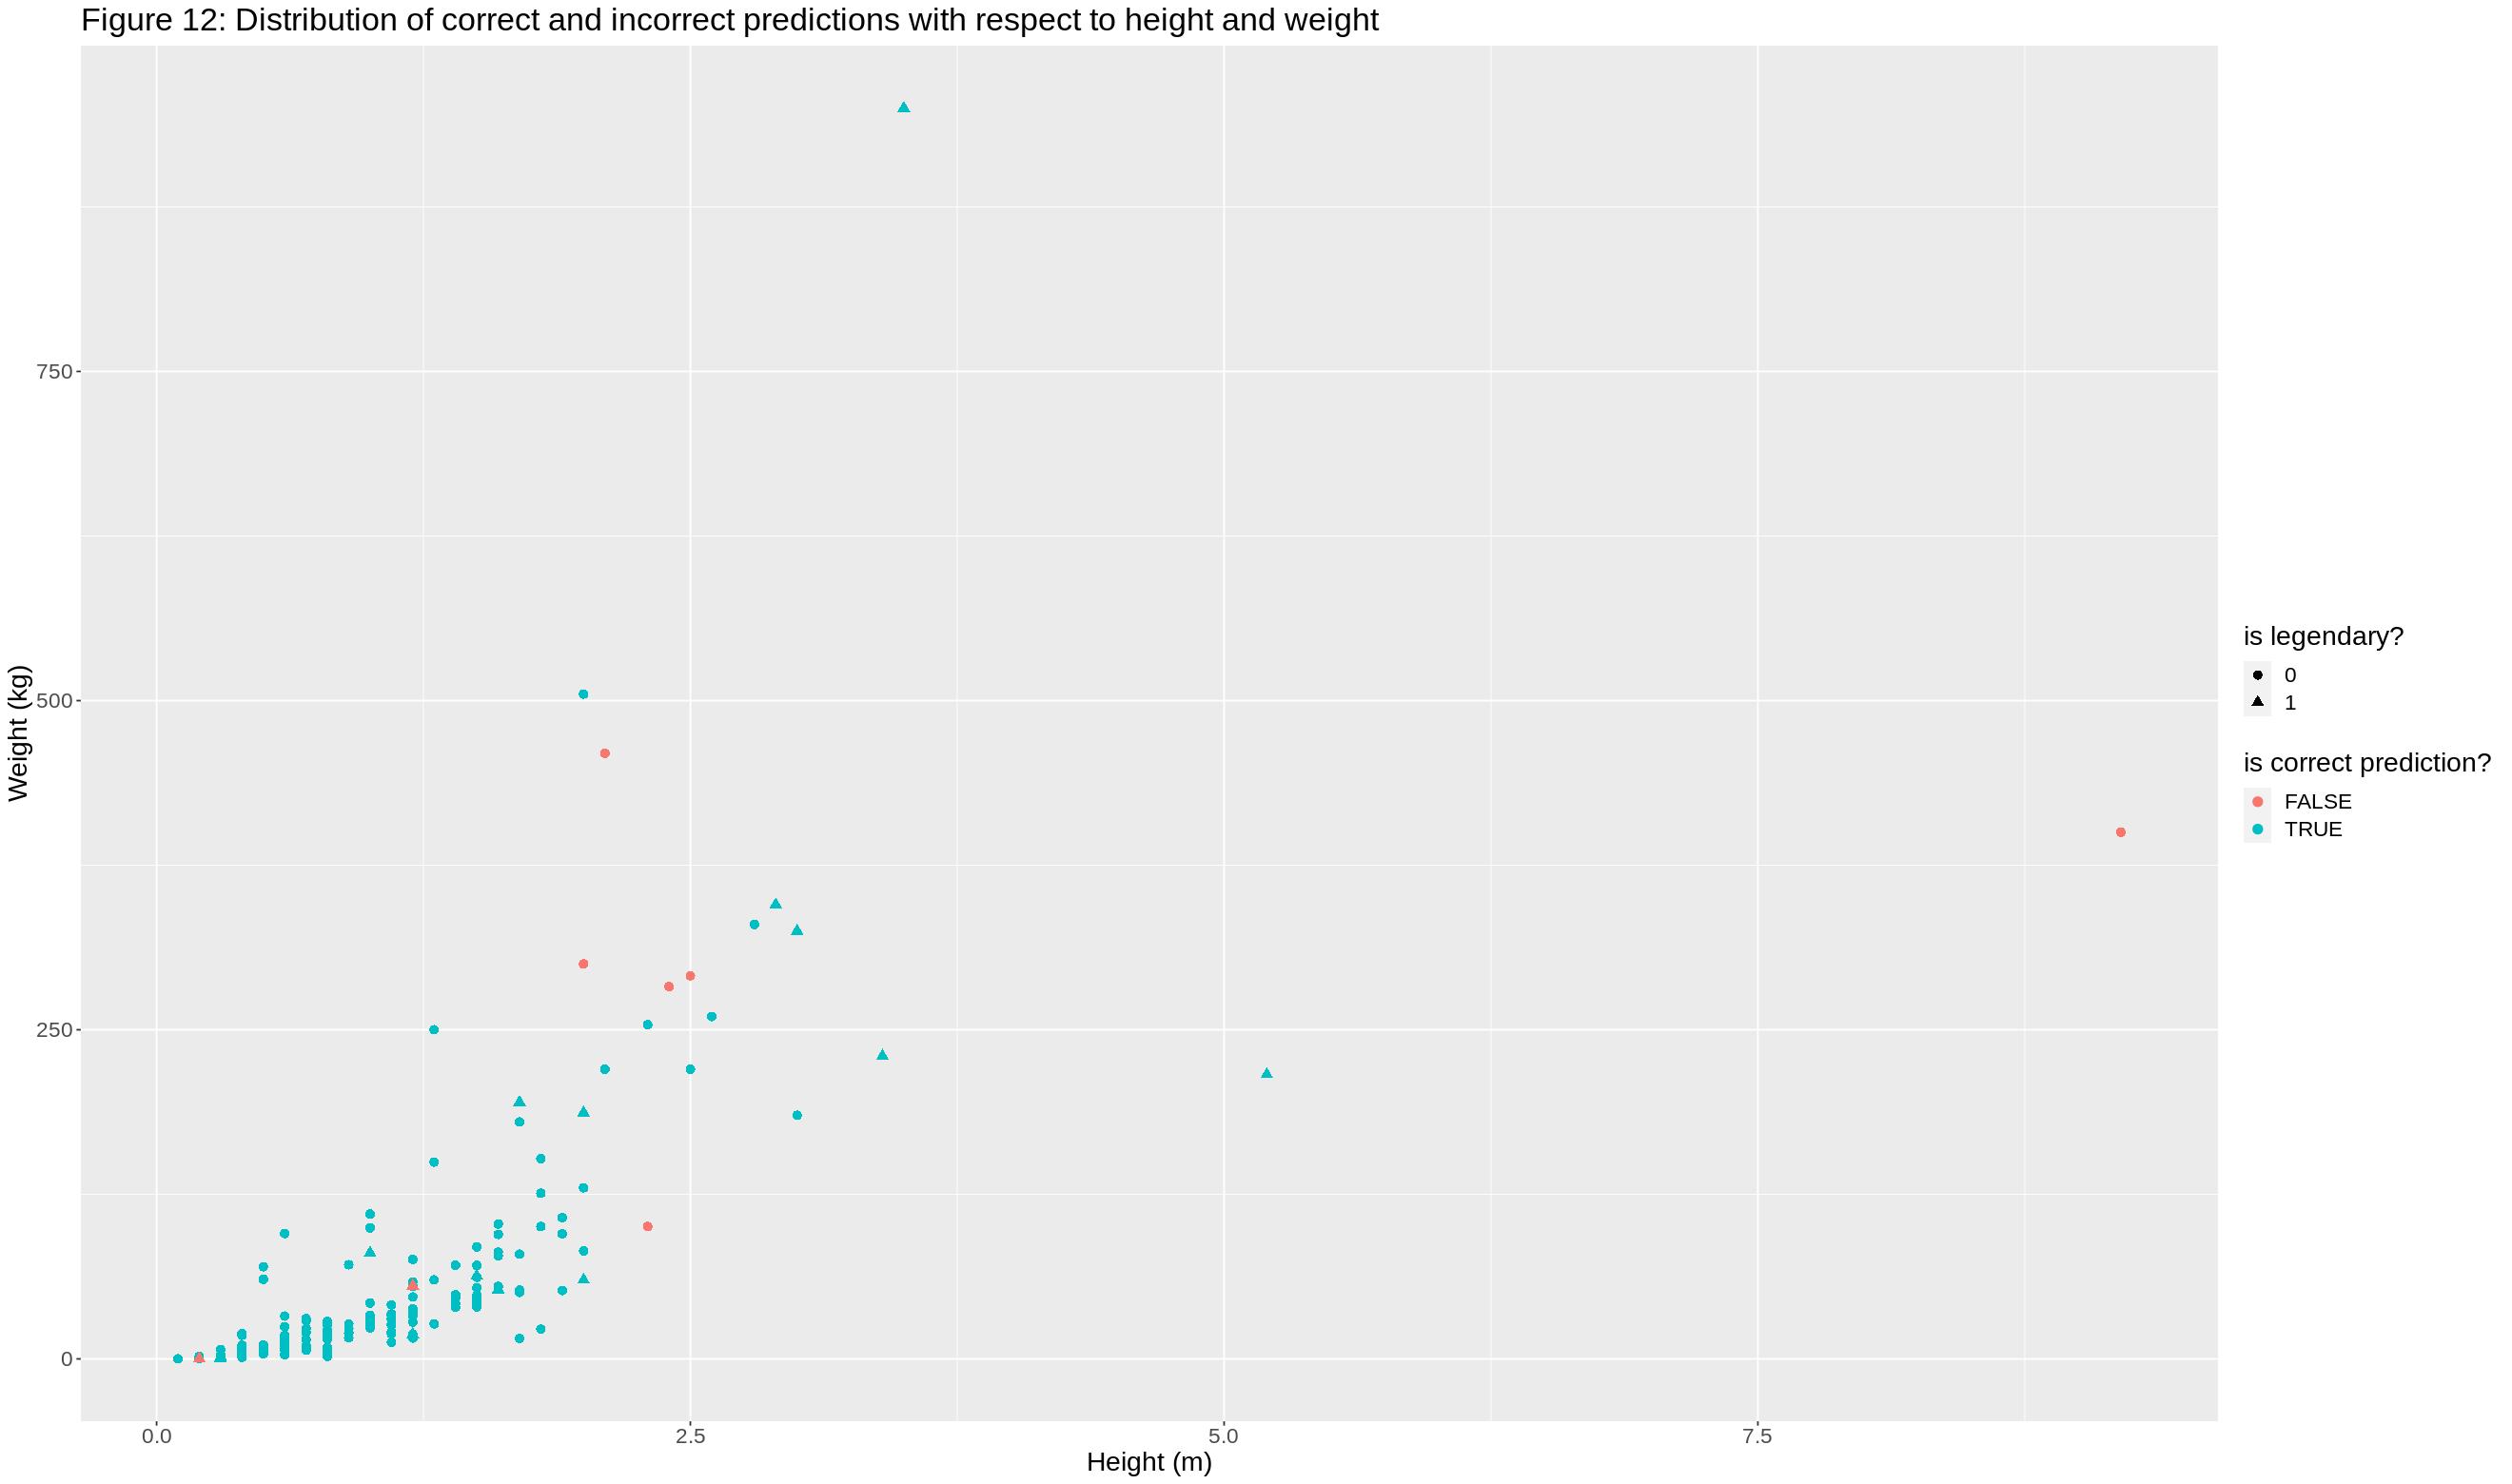

In [14]:
# visualizing which pokemon in testing set were predicted incorrectly

pokemon_correct_predictions <- pokemon_predictions |>
                                mutate(correct_prediction = (.pred_class == is_legendary))


options(repr.plot.width = 22, repr.plot.height = 13) 

pokemon_correct_predictions_height_weight_plot <- ggplot(pokemon_correct_predictions, aes(x = height_m, y = weight_kg, shape = is_legendary, color = correct_prediction)) +
                                        geom_point(size = 2.5) +
                                        labs(x = "Height (m)", y = "Weight (kg)", shape = "is legendary?", color = "is correct prediction?") +
                                        ggtitle("Figure 12: Distribution of correct and incorrect predictions with respect to height and weight") +
                                        theme(text = element_text(size = 17))

pokemon_correct_predictions_height_weight_plot

Figure 12 above shows the height in meters on the x axis and the weight in kilograms on the y axis. Legendary pokemon are shown as triangle points, while non-legendary pokemon are shown as circular points. Finally, blue points are shown as correct predictions, while red points are shown as incorrect predictions. So for example, the rightmost point on the graph has a height of around 9m, a weight of around 400kg, is not legendary, and was predicted incorrectly, meaning it was predicted to be legendary. <br><br><br>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



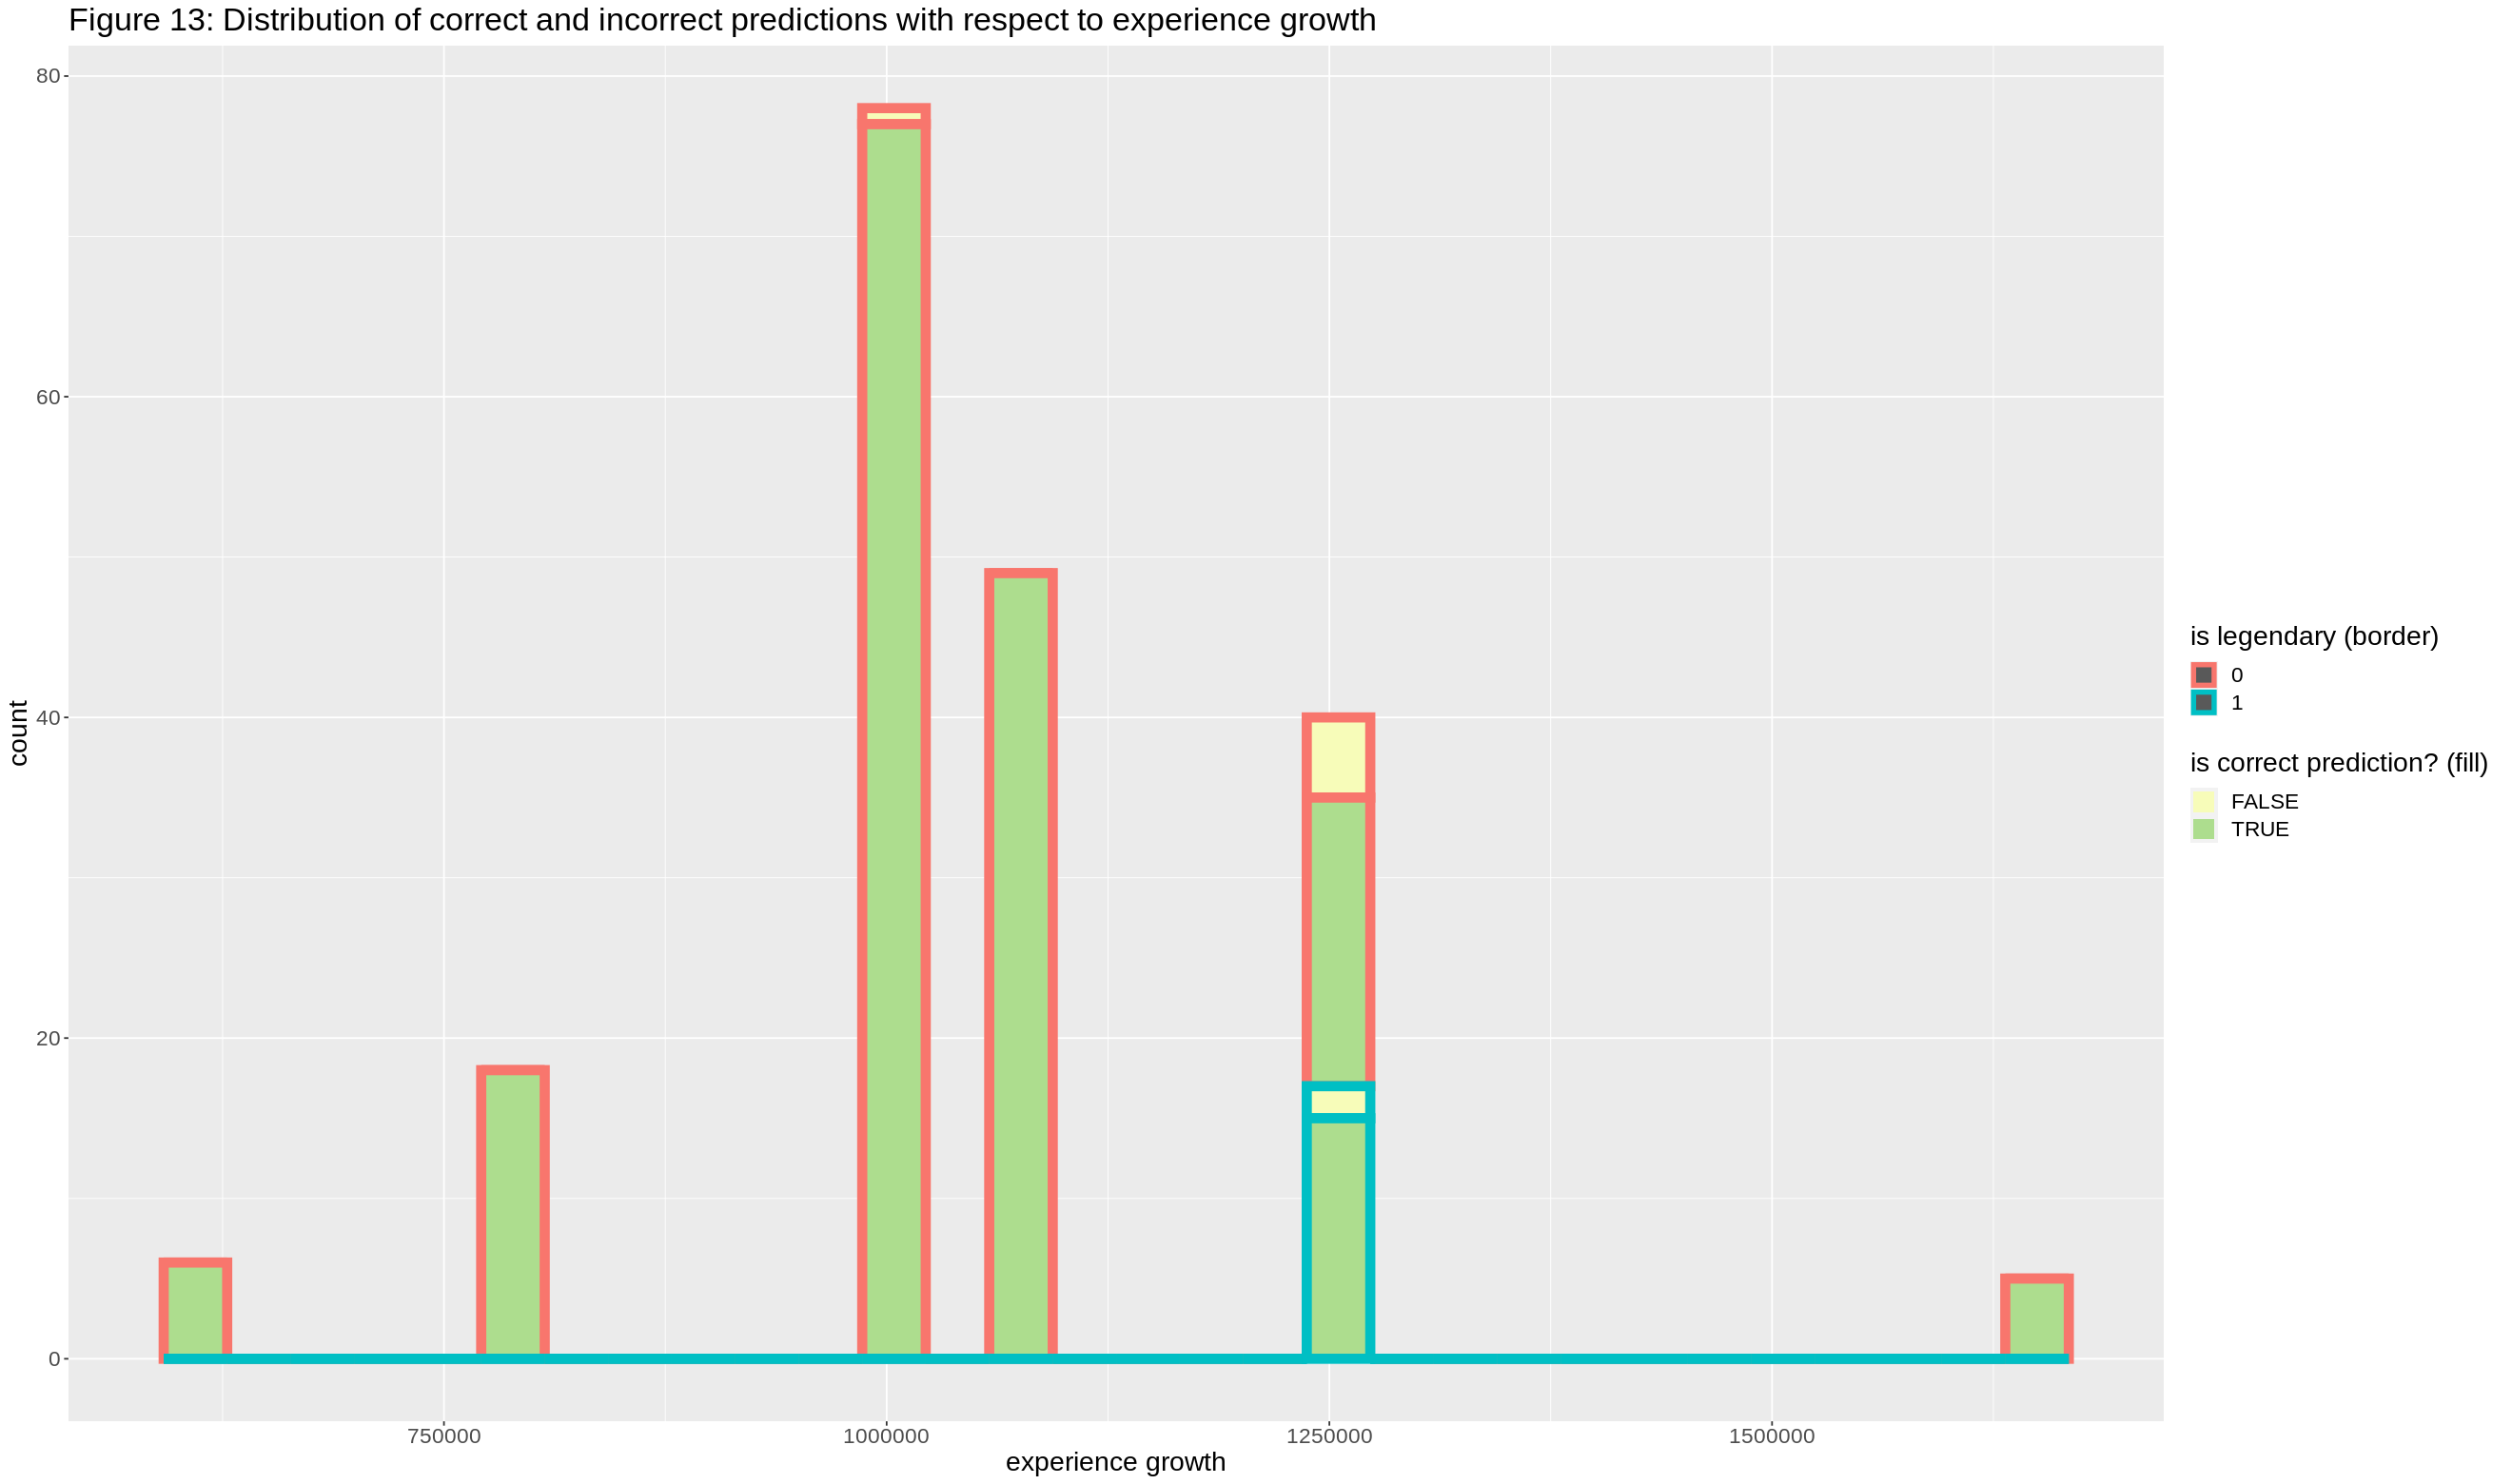

In [15]:
pokemon_correct_predictions_experience_growth_plot <- ggplot(pokemon_correct_predictions, aes(x = experience_growth, color = is_legendary, fill = correct_prediction)) +
                                        geom_histogram(size = 3) +
                                        scale_fill_brewer(palette = "YlGn") +
                                        labs(x = "experience growth", color = "is legendary (border)", fill = "is correct prediction? (fill)") +
                                        ggtitle("Figure 13: Distribution of correct and incorrect predictions with respect to experience growth") +
                                        theme(text = element_text(size = 17))

pokemon_correct_predictions_experience_growth_plot

Figure 13 above shows the experience growth on the x axis, and the quantity of pokemon that have a certain experience growth on the y axis. The amount of legendary pokemon are marked with a blue border, while the amount of non-legendary pokemon are marked with a red border. Correct predictions are filled with green, while incorrect predictions are filled with yellow. For example, let's look at the bar at experience growth = 1250000. The lowest section has a blue border and green fill, which means that these pokemon are legendary and were correctly predicted to be legendary. The next section up has a blue border and yellow fill, which means that these pokemon are legendary and incorrectly predicted to be non-legendary. The next section up has a red border and green fill, which means that these pokemon are not legendary and correctly predicted to be not legendary. The highest section has a red border and yellow fill, which means that these pokemon are not legendary and incorrectly predicted to be legendary. <br><br><br>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



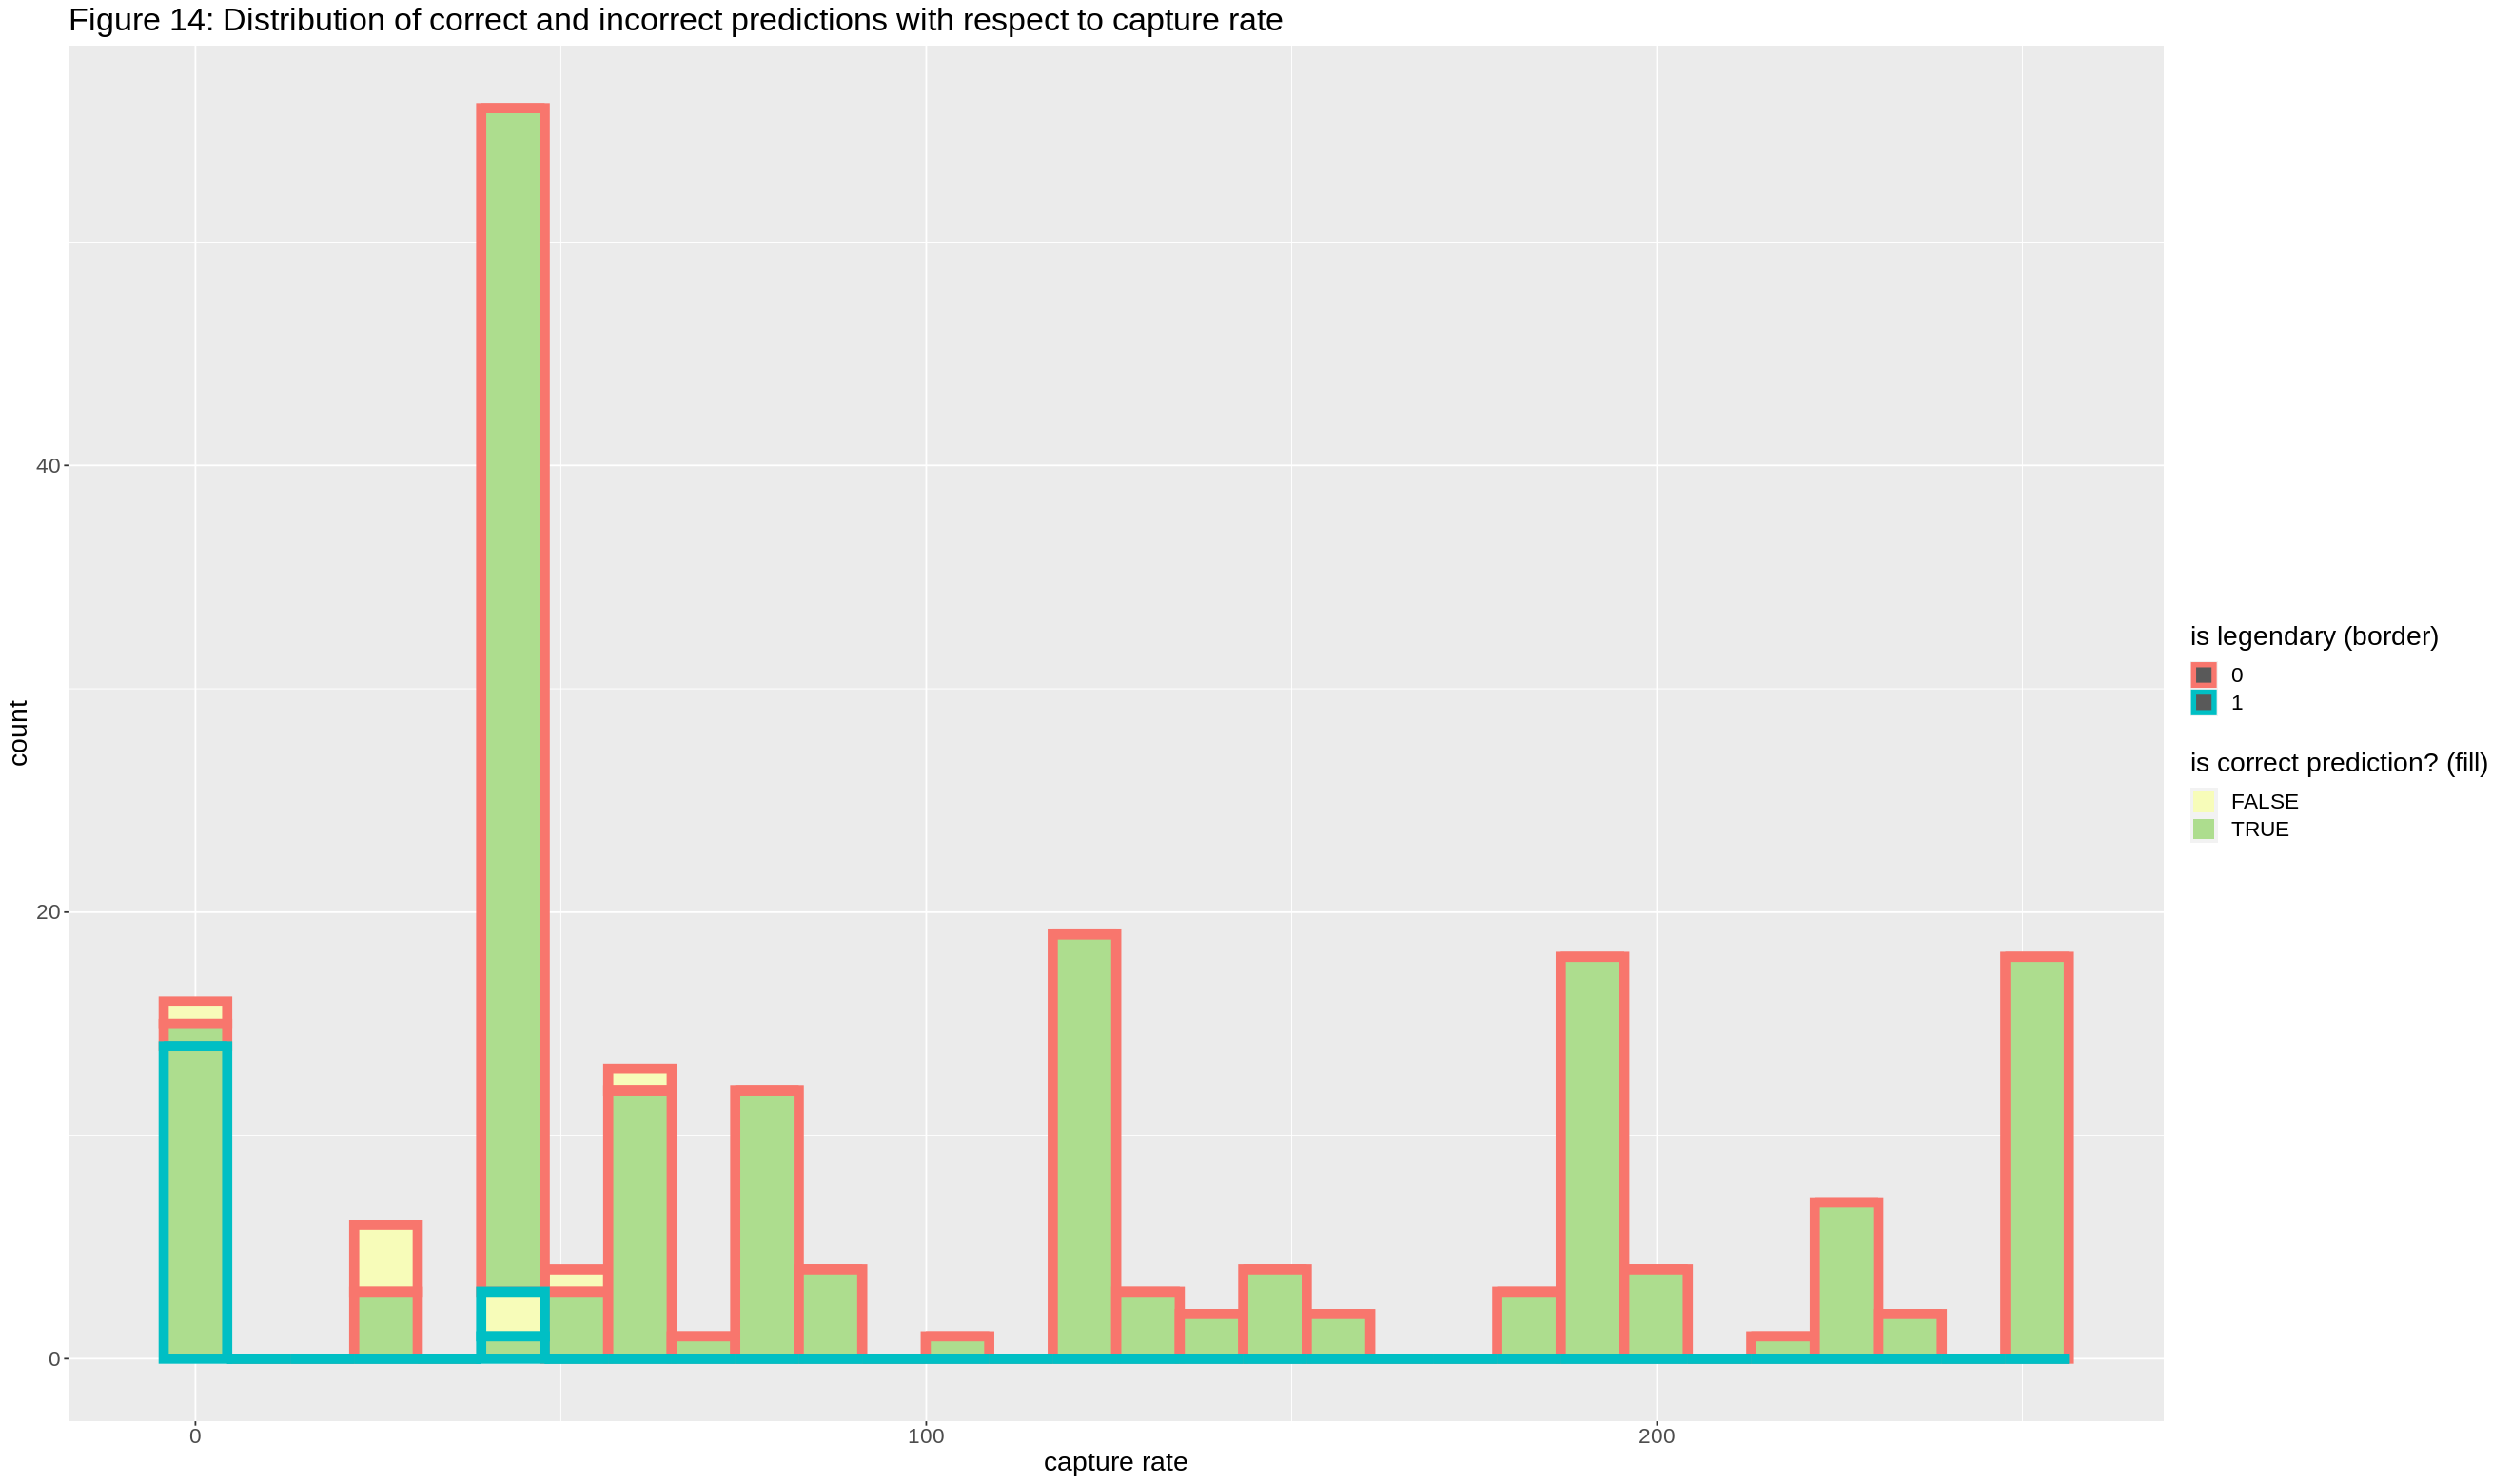

In [16]:
pokemon_correct_predictions_capture_rate_plot <- ggplot(pokemon_correct_predictions, aes(x = capture_rate, color = is_legendary, fill = correct_prediction)) +
                                        geom_histogram(size = 3) +
                                        scale_fill_brewer(palette = "YlGn") +
                                        labs(x = "capture rate", color = "is legendary (border)", fill = "is correct prediction? (fill)") +
                                        ggtitle("Figure 14: Distribution of correct and incorrect predictions with respect to capture rate") +
                                        theme(text = element_text(size = 17))

pokemon_correct_predictions_capture_rate_plot

Figure 14 above shows the capture rate on the x axis, and the quantity of pokemon that have a certain capture rate on the y axis. The amount of legendary pokemon are marked with a blue border, while the amount of non-legendary pokemon are marked with a red border. Correct predictions are filled with green, while incorrect predictions are filled with yellow. <br><br><br>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



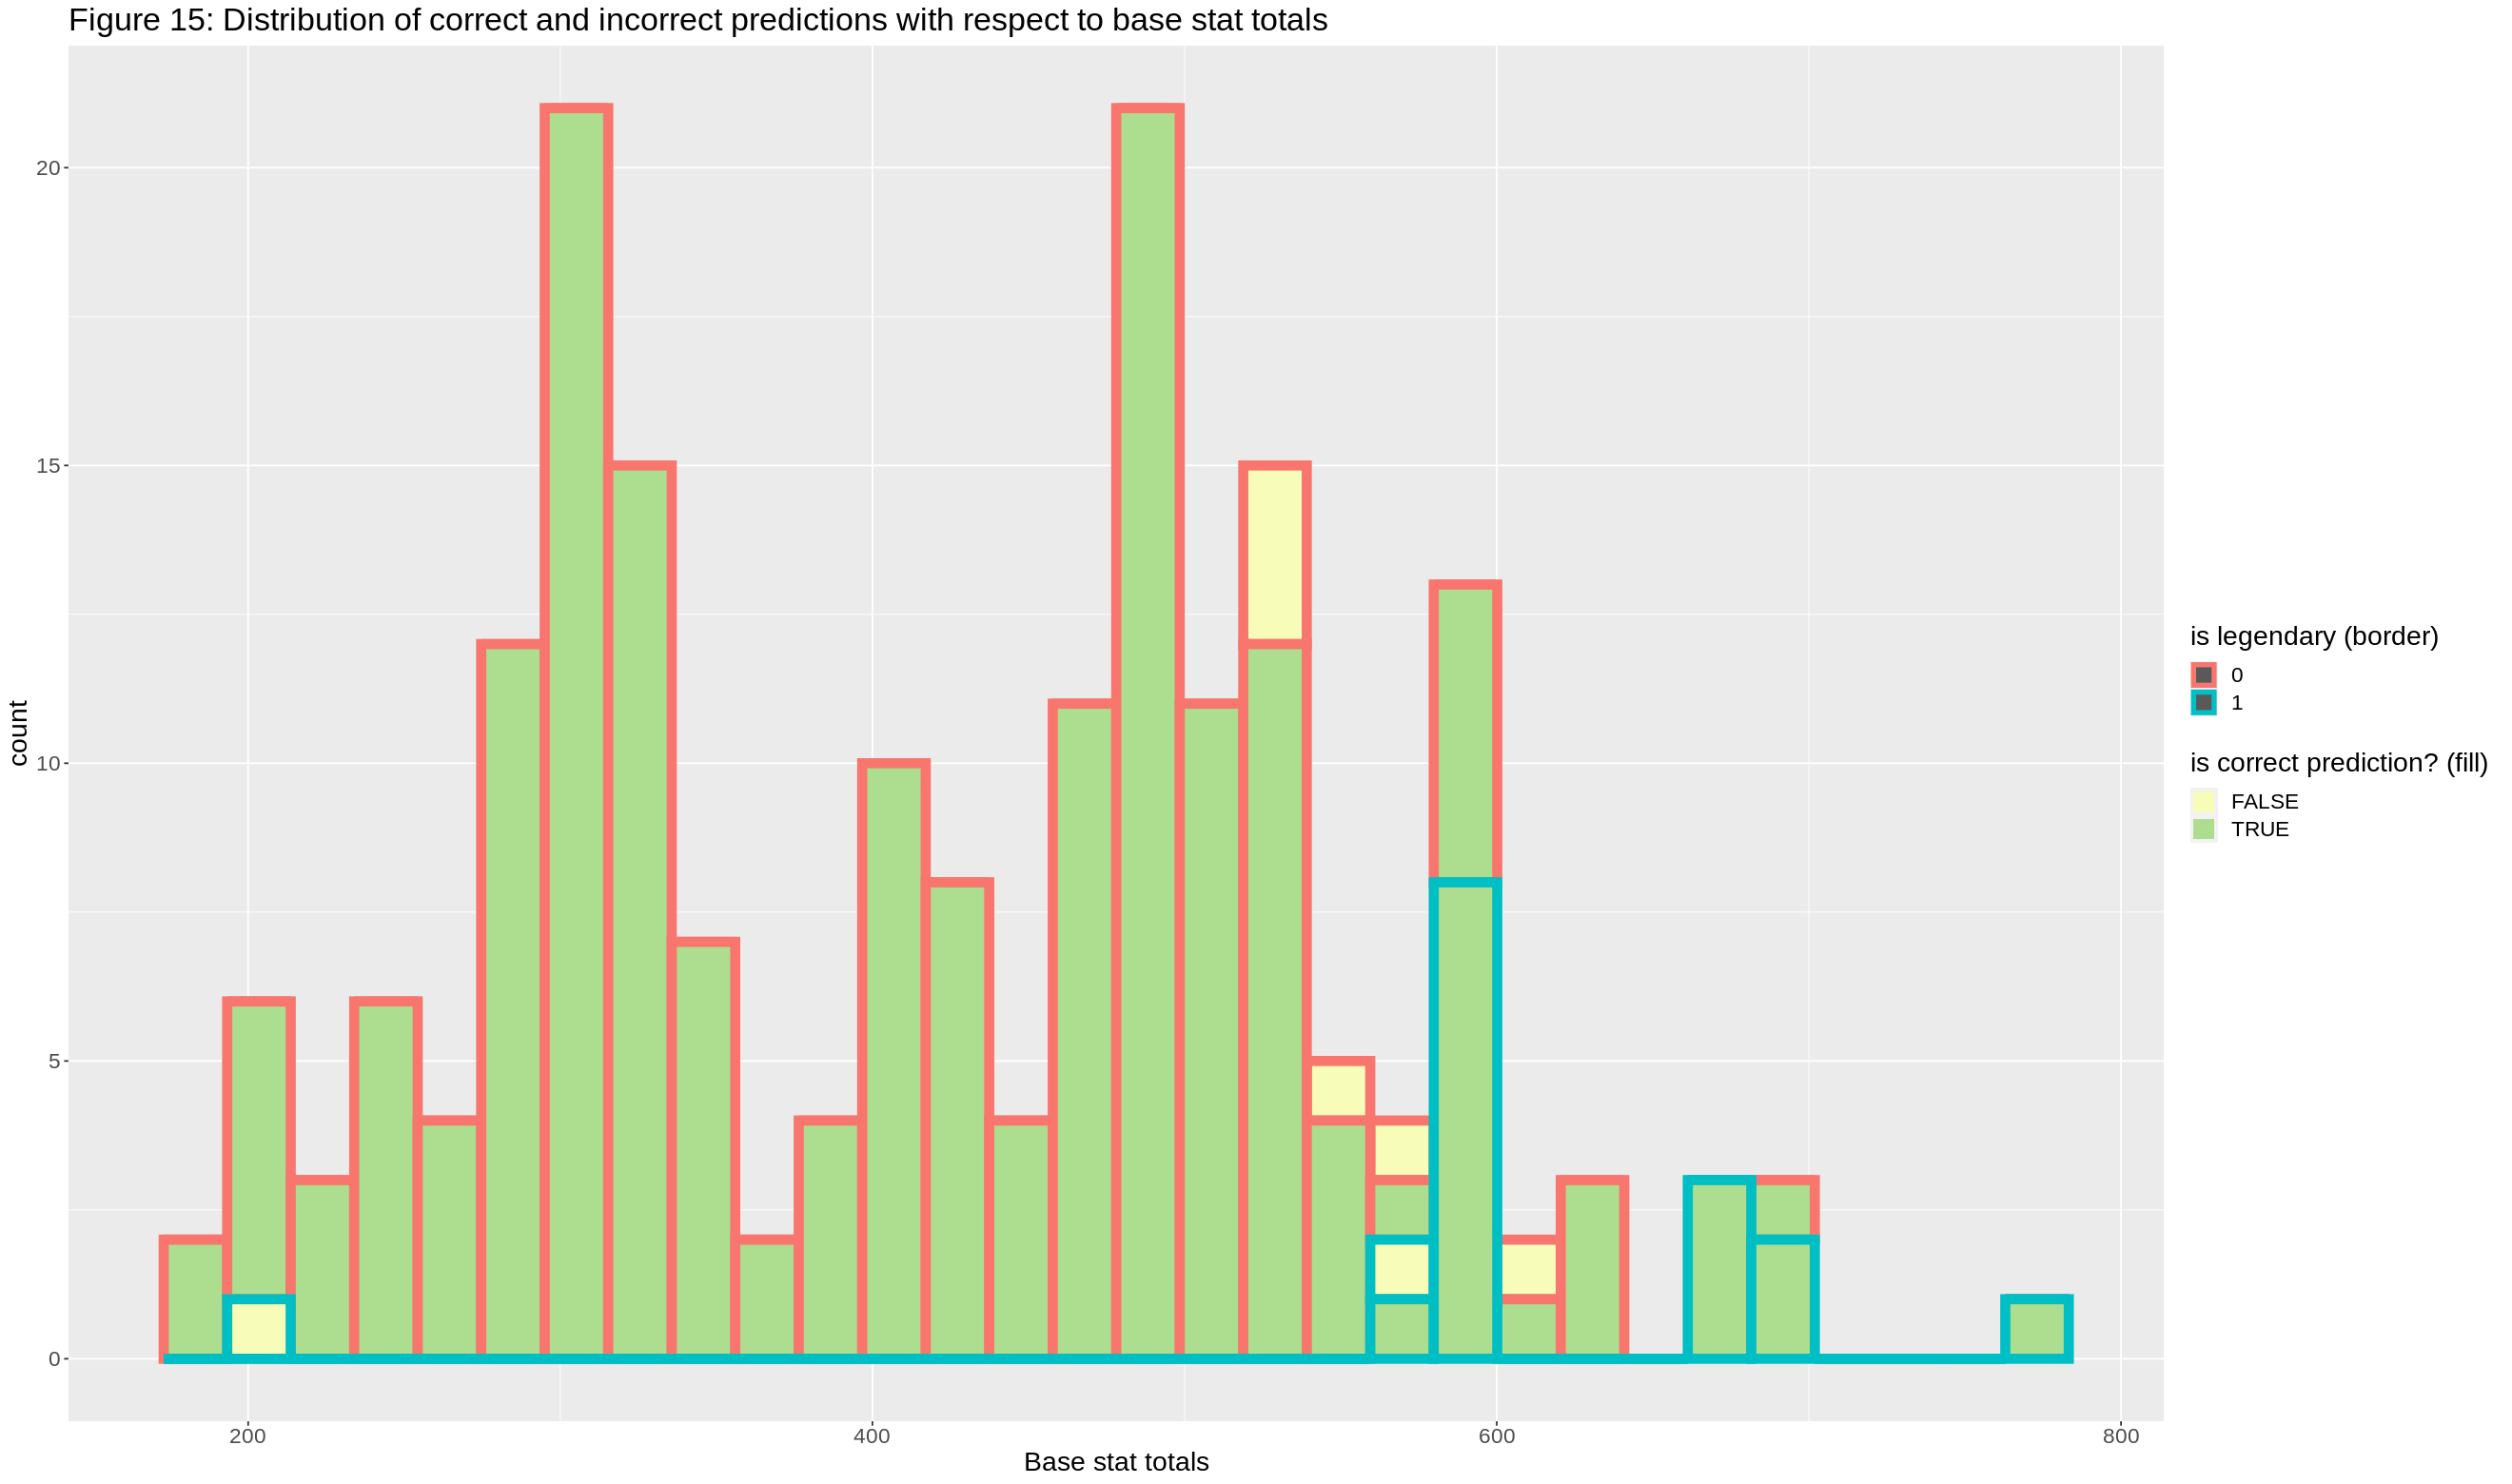

In [17]:

pokemon_correct_predictions_base_total_plot <- ggplot(pokemon_correct_predictions, aes(x = base_total, color = is_legendary, fill = correct_prediction)) +
                                        geom_histogram(size = 3) +
                                        scale_fill_brewer(palette = "YlGn") +
                                        labs(x = "Base stat totals", color = "is legendary (border)", fill = "is correct prediction? (fill)") +
                                        ggtitle("Figure 15: Distribution of correct and incorrect predictions with respect to base stat totals") +
                                        theme(text = element_text(size = 17))

pokemon_correct_predictions_base_total_plot

Figure 15 above shows the base stat totals on the x axis, and the quantity of pokemon that have a certain base stat total on the y axis. The amount of legendary pokemon are marked with a blue border, while the amount of non-legendary pokemon are marked with a red border. Correct predictions are filled with green, while incorrect predictions are filled with yellow. <br><br><br>

## Discussion:

In [18]:
num_test_legendaries <- pokemon_test |>
                    group_by(is_legendary) |>
                    summarize(count = n())
num_test_legendaries

is_legendary,count
<fct>,<int>
0,179
1,17


Table above is table 16, which shows the number of legendary and non-legendary pokemon in the testing set. (will be referenced later)

<br><br>
From our data analysis, we were able to correctly determine between legendary and non-legendary pokemon in our testing subset with 95.91% accuracy. Our testing dataset contains 179 regular pokemon and 17 legendary pokemon from table 16, so about ~91% of the pokemon are non-legendary.  That means that a majority classifier that always guesses non-legendary would have ~91% accuracy, and so our model is better than the majority classifier by about 5%. This is a significant improvement, because the “gap” between 100% accuracy and the majority classifier’s accuracy is 9%, and our model “closes that gap” more than halfway. Also, given that predicting whether pokemon is legendary is not a life or death situation, there is no need for extremely accurate models anyways. Therefore, our model is performing appropriately for our purposes. <br>


This result was also within our expectations since plots of our prediction variables for the training sets showed trends that supported k-nearest neighbors classification. On average, legendary pokemon tend to have greater weight and height, greater experience growth values, lower capture rates, and higher base stat totals. Since all predictors had clear differences between legendary and non-legendary pokemon, it would be reasonable to assume that using all 5 together would result in a high degree of accuracy. <br>

For the incorrect predictions, we can see that legendaries with smaller heights and weights, as well as non-legendaries with larger heights and weights, tend to be predicted incorrectly. This is expected as legendaries usually have larger heights and weights. <br> <br>
In terms of experience growth, we can see that most of the incorrect predictions are from non-legendary pokemon with 1250000 experience growth. This is expected because in the training dataset, almost all of the legendary pokemon had 1250000 experience growth. <br><br>
In terms of capture rate, we can see that most of the incorrect predictions are from legendaries with higher (relatively speaking) capture rates, and non-legendaries with lower capture rates. This is expected because legendary pokemon tend to have lower capture rates. <br><br>
In terms of base stat totals, we see that most of the incorrect predictions are from legendaries with lower base stat totals and non-legendaries with higher base stat totals. This is expected because legendary pokemon tend to have higher base stat totals. <br><br>

Within the scope of Pokemon, our findings can be used to help classify and group pokemon depending on how similar they are to legendary pokemon. This may help in competitive scenes to determine power rankings between various pokemon and in determining which Pokemons may be used or prohibited. It may also help in identifying datamines of Pokemon in new games that come out, determining which Pokemon could be classified as Legendary. Outside of Pokemon, our findings show the effectiveness of K-nearest neighbors as a form of data analysis and shows how the use of 5 predictor variables increases the accuracy of predictions. <br>

This project could lead to future questions like: What other characteristics of a pokemon can predict whether they are legendary (e.g. typing) ? Can these same characteristics predict whether a pokemon is mythical? (another type of rare pokemon) <br>


## References

1. https://bulbapedia.bulbagarden.net/wiki/Legendary_Pok%C3%A9mon
2. https://www.kaggle.com/datasets/rounakbanik/pokemon
3. https://bulbapedia.bulbagarden.net/wiki/Experience#Slow
